In [1]:
#   Delayed = 1 if Arrival Delay > 15 minutes
#   Delayed = 0 otherwise


In [2]:
import pandas as pd
df = pd.read_csv("ready_for_modeling.csv")

df.shape

(1500000, 20)

In [3]:
# Train Validation Split

from sklearn.model_selection import train_test_split

X = df.drop(columns=['DELAYED'])
y = df['DELAYED']

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=False
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

print("Target Train Shape",y_train.shape)
print("Target Validation Shape",y_val.shape)

print("Train target distribution:")
print(y_train.value_counts(normalize=True))

print("Validation target distribution:")
print(y_val.value_counts(normalize=True))



Train shape: (1200000, 19)
Validation shape: (300000, 19)
Target Train Shape (1200000,)
Target Validation Shape (300000,)
Train target distribution:
DELAYED
0    0.821649
1    0.178351
Name: proportion, dtype: float64
Validation target distribution:
DELAYED
0    0.821053
1    0.178947
Name: proportion, dtype: float64


In [ ]:
# Logistic Regression Model

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

In [5]:
model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [6]:
# Logistic Regression Model Evaluation

from sklearn.metrics import roc_auc_score, classification_report

y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

print("ROC AUC:", roc_auc_score(y_val, y_prob))
print(classification_report(y_val, y_pred))



ROC AUC: 0.6965554827607912
              precision    recall  f1-score   support

           0       0.89      0.62      0.73    246316
           1       0.27      0.66      0.39     53684

    accuracy                           0.62    300000
   macro avg       0.58      0.64      0.56    300000
weighted avg       0.78      0.62      0.67    300000



In [7]:
# Fitting Random Forest Model and Evaluation


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Initialize model
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_val)
y_prob_rf = rf.predict_proba(X_val)[:, 1]

# Evaluate
print("ROC-AUC:", roc_auc_score(y_val, y_prob))
print(classification_report(y_val, y_pred))


ROC-AUC: 0.6965554827607912
              precision    recall  f1-score   support

           0       0.89      0.62      0.73    246316
           1       0.27      0.66      0.39     53684

    accuracy                           0.62    300000
   macro avg       0.58      0.64      0.56    300000
weighted avg       0.78      0.62      0.67    300000




Confusion Matrix @ Threshold 0.3:
[[ 79348 166968]
 [  2933  50751]]

Confusion Matrix @ Threshold 0.5:
[[211541  34775]
 [ 16143  37541]]

Confusion Matrix @ Threshold 0.7:
[[244407   1909]
 [ 34565  19119]]

Metrics across thresholds:
   Threshold  Precision    Recall  F1-score
0        0.3   0.233103  0.945365  0.373990
1        0.5   0.519124  0.699296  0.595889
2        0.7   0.909216  0.356140  0.511805


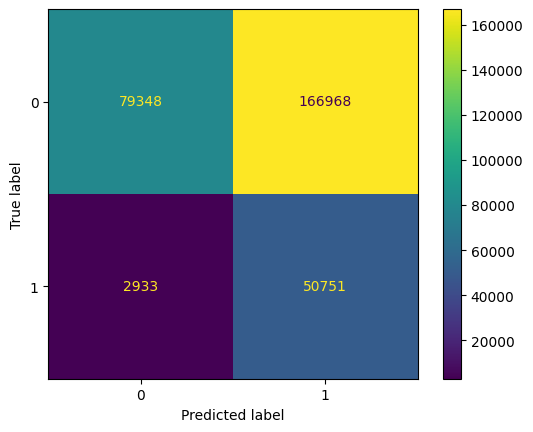

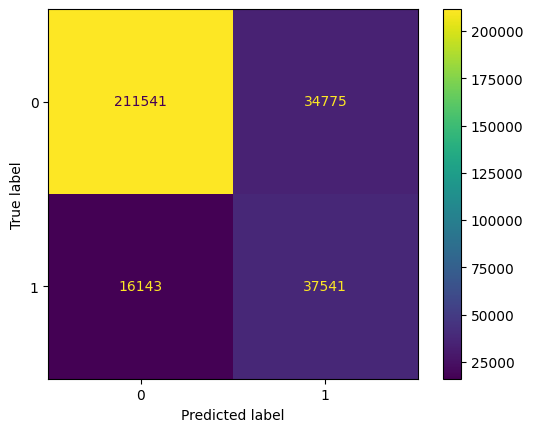

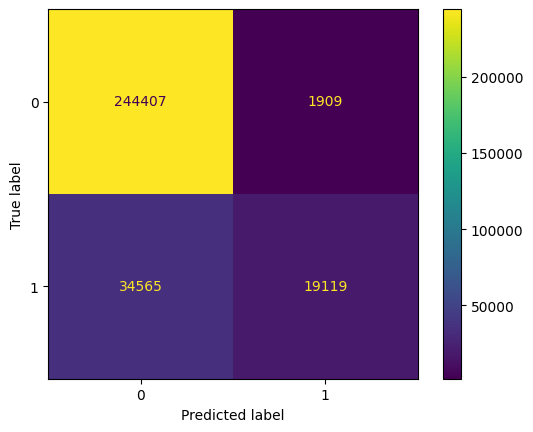

In [9]:
# Import libraries
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# Variables:
# y_val        -> true labels
# y_pred_rf    -> default predictions (not using for threshold analysis)
# y_prob_rf    -> predicted probabilities from Random Forest

# Define thresholds to test
thresholds = [0.3, 0.5, 0.7]

results = []

for t in thresholds:
    # Converting probabilities to binary predictions based on threshold
    y_pred_thresh = (y_prob_rf >= t).astype(int)
    
    # Calculating metrics
    precision = precision_score(y_val, y_pred_thresh)
    recall = recall_score(y_val, y_pred_thresh)
    f1 = f1_score(y_val, y_pred_thresh)
    
    results.append({
        "Threshold": t,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    })
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred_thresh)
    print(f"\nConfusion Matrix @ Threshold {t}:")
    print(cm)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

# Displaying metrics for all thresholds
df_results = pd.DataFrame(results)
print("\nMetrics across thresholds:")
print(df_results)


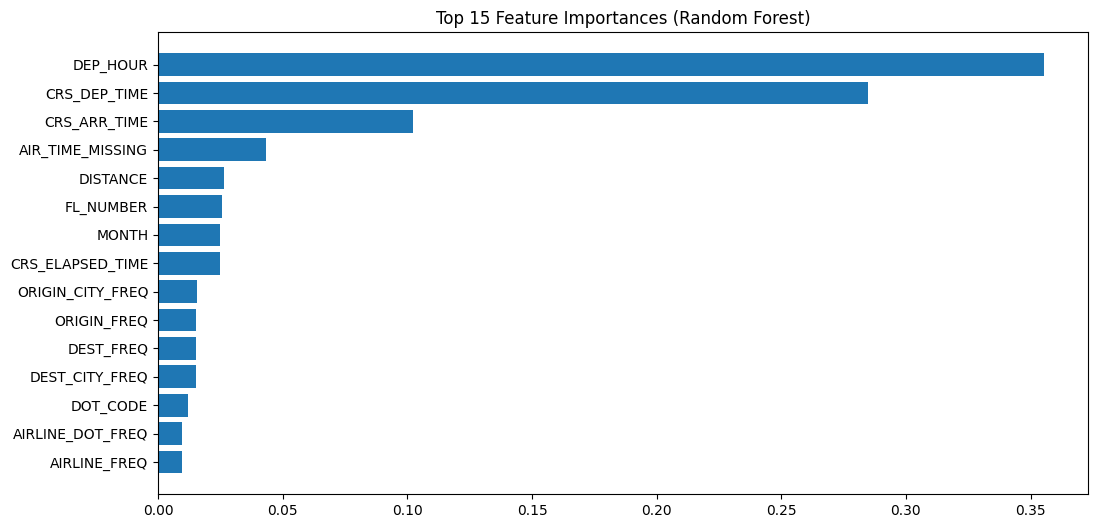

In [10]:

import matplotlib.pyplot as plt
import pandas as pd

feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
plt.barh(feat_imp['feature'].head(15), feat_imp['importance'].head(15))
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

In [12]:
import pandas as pd

# Assuming feature_importances_ is from your trained RF
feat_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feat_importance)


                     feature    importance
9                   DEP_HOUR  3.553148e-01
2               CRS_DEP_TIME  2.847708e-01
3               CRS_ARR_TIME  1.021220e-01
10          AIR_TIME_MISSING  4.334509e-02
5                   DISTANCE  2.627952e-02
1                  FL_NUMBER  2.543891e-02
6                      MONTH  2.481186e-02
4           CRS_ELAPSED_TIME  2.468452e-02
17          ORIGIN_CITY_FREQ  1.564286e-02
12               ORIGIN_FREQ  1.535858e-02
13                 DEST_FREQ  1.516948e-02
18            DEST_CITY_FREQ  1.500699e-02
0                   DOT_CODE  1.218514e-02
15          AIRLINE_DOT_FREQ  9.721093e-03
14              AIRLINE_FREQ  9.535406e-03
7                DAY_OF_WEEK  9.506062e-03
16         AIRLINE_CODE_FREQ  9.210497e-03
8                 IS_WEEKEND  1.896459e-03
11  CRS_ELAPSED_TIME_MISSING  2.508889e-14


In [13]:
# List of features to keep (above importance threshold)
important_features = feat_importance[feat_importance['importance'] > 0.01]['feature'].tolist()

# Filter training and validation data
X_train_reduced = X_train[important_features]
X_val_reduced = X_val[important_features]


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)

# Evaluate
y_prob_reduced = rf_reduced.predict_proba(X_val_reduced)[:,1]
roc_auc_reduced = roc_auc_score(y_val, y_prob_reduced)

print(f"ROC-AUC with reduced features: {roc_auc_reduced:.3f}")


ROC-AUC with reduced features: 0.845
